In [ ]:
## @see https://www.kaggle.com/toorkp/churn-wsdm/data

In [1]:
%load_ext autoreload
%autoreload

In [5]:
import numpy as np
import pandas as pd
import time
import gc; gc.enable()
import time
import sys

from sklearn import model_selection
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_curve, auc, confusion_matrix, f1_score, log_loss, confusion_matrix
from sklearn.neural_network import MLPClassifier

from collections import Counter
from numpy.random import RandomState
from imblearn.over_sampling import SMOTENC
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
import xgboost as xgb

pd.options.display.float_format = "{:.2f}".format
np.set_printoptions(precision=4)

import matplotlib.pyplot as plt
%matplotlib inline

sys.path.append('modules')

from shared_functions import *

import pickle
from datetime import datetime

In [3]:
# Load the pre-split data

store = pd.HDFStore('/home/dissertation/data/feat_eng_abt_split.h5')
X_train = store['X_train']
X_test = store['X_test']
y_train = store['y_train']
y_test = store['y_test']
store.close()

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

# Drop msno from the dataset
X_train.drop(['msno'], inplace=True, axis=1)
X_test.drop(['msno'], inplace=True, axis=1)

X_train.head()

## Create a list of the categorical columns in the dataset
cat_col = ['gender', 'city', 'registered_via', 'payment_method_id_mode']

(600803, 19) (600803,)
(257487, 19) (257487,)


In [ ]:
import sklearn 
sklearn.metrics.SCORERS.keys()

In [ ]:
## WHAT METRIC SHOULD BE OPTIMSED AS PART OF CV

In [20]:
RANDOM_STATE = 42 
CV_ITER = 5
SCORING_METRIC = 'recall'
BASE_NAME = "grid_" + str(CV_ITER) + "cv_" + SCORING_METRIC

## Each entry in the list is a Tuple of
##   [ModelName, Model, HyperParams, ScoringMetric]
classifiers = [
    ('NB_' + BASE_NAME, GaussianNB(), {}, SCORING_METRIC),   
    ('DT_' + BASE_NAME, DecisionTreeClassifier(random_state=RANDOM_STATE), 
                    {"criterion": ["entropy"], 
                     "max_depth":[10,25], 
                     "min_samples_leaf":[10,15,20],
                     "min_samples_split":[2,4,1000],
                     "class_weight":[None, "balanced"],
                     "presort" : [True, False]}, 
           SCORING_METRIC),    
    ('RF_' + BASE_NAME, RandomForestClassifier(random_state=RANDOM_STATE, n_jobs =-1), 
                    {"criterion": ["entropy"], 
                     "n_estimators": [100,150],
                     "max_depth":[10,25], 
                     "min_samples_leaf":[10,15],
                     "min_samples_split":[2,4],
                     "class_weight":[None, "balanced"]},
           SCORING_METRIC),
    ('LR_' + BASE_NAME, LogisticRegression(random_state=RANDOM_STATE), 
                    {"solver" : ['newton-cg', 'lbfgs', 'liblinear','saga'],
                     "class_weight": [None, "balanced"],
                     "max_iter": [100, 200],
                     "C": [1,2]}, 
           SCORING_METRIC),
    ('MLP_' + BASE_NAME, MLPClassifier(random_state=RANDOM_STATE), 
                    {"hidden_layer_sizes": [(50,), (100,)],
                     "activation": ["tanh", "relu"],
                     "alpha": [0.0001, 0.001]}, 
            SCORING_METRIC),
    ('XGB_' + BASE_NAME, xgb.XGBClassifier(random_state=RANDOM_STATE, objective="binary:logistic", n_jobs=8), 
                    {"n_estimators": [100,200,300],
                     "max_depth": [1,3,6],
                     "learning_rate": [0.0001, 0.001, 0.01]
                    }, SCORING_METRIC) 
]

TypeError: __init__() got an unexpected keyword argument 'random_state'

In [7]:
all_metrics = pd.DataFrame()
all_results = list()

### Experiment 1.1 Baseline - Default Settings - No sampling

Model Build Iteration 0
PRE-SAMPLING: (600803, 18) (600803,) Counter({0: 544661, 1: 56142})
POST-SAMPLING: (600803, 18) (600803,) Counter({0: 544661, 1: 56142})
Set the train df types correctly based on the test set
Applying normalisation to train and test sets
Categorical columns in dataset ['gender', 'city', 'registered_via', 'payment_method_id_mode']
Categorical columns in dataset ['gender', 'city', 'registered_via', 'payment_method_id_mode']
X_train:  (600803, 52) (600803, 1)
X_test:  (257487, 52) (257487, 1)


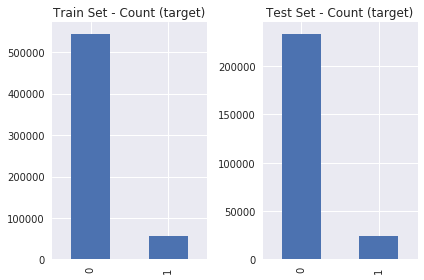

Training NB_grid_5cv_recall classifier
No params set, using Standard training
Generating test scores for NB_grid_5cv_recall classifier
Performing 5-fold CV on test set using recall metric
Training DT_grid_5cv_recall classifier
Optimising using GridSearchCV
Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


In [ ]:
%%time
start = time.time()

sampler = ('None', DummySampler())

exp_metrics, model_results = perform_experiment(X_train, X_test, y_train, y_test, classifiers, sampler, 1, \
                                                cv_iter=CV_ITER, cat_col=cat_col)

all_metrics = all_metrics.append(exp_metrics)
all_results.append((sampler[0]+"_"+BASE_NAME, exp_metrics, model_results))

log("manual, grid_search, {0}, {1}".format(sampler[0], time.time()-start), 'Manual_GridSearch.log')

In [11]:
all_metrics.sort_values('f1_score', ascending=False)

,label,classifier,sampling_method,tn,fn,tp,fp,accuracy,precision,recall,...,log_loss,train_time,cv_time,aucroc,auprc,balanced_accuracy,cv_score_mean,cv_score_std,model_churn_cost,sample
0,MLP_grid_5cv_recall,MLPClassifier,RUS 1:1,218083,11800,12261,15343,0.89,0.44,0.51,...,3.64,143.42,759.88,0.81,0.49,0.72,0.25,0.02,8660400,0
0,RF_grid_5cv_recall,RandomForestClassifier,RUS 1:1,196594,5562,18499,36832,0.84,0.33,0.77,...,5.69,456.76,39.08,0.88,0.58,0.81,0.32,0.00,8314100,0
0,RF_grid_5cv_recall,RandomForestClassifier,None,198211,6108,17953,35215,0.84,0.34,0.75,...,5.54,3808.09,36.38,0.87,0.55,0.80,0.73,0.01,8370800,0
0,XGB_grid_5cv_recall,XGBClassifier,RUS 1:1,196254,5977,18084,37172,0.83,0.33,0.75,...,5.79,1060.60,203.15,0.87,0.56,0.80,0.30,0.01,8514100,0
0,DT_grid_5cv_recall,DecisionTreeClassifier,RUS 1:1,192205,5782,18279,41221,0.82,0.31,0.76,...,6.31,306.27,2.76,0.87,0.55,0.79,0.28,0.02,8841000,0
0,DT_grid_5cv_recall,DecisionTreeClassifier,None,189288,4989,19072,44138,0.81,0.30,0.79,...,6.59,9849.19,15.65,0.87,0.58,0.80,0.77,0.00,8815500,0
0,XGB_grid_5cv_recall,XGBClassifier,None,231969,17216,6845,1457,0.93,0.82,0.28,...,2.50,4915.03,200.61,0.87,0.58,0.64,0.30,0.01,9438200,0
0,MLP_grid_5cv_recall,MLPClassifier,None,230646,17176,6885,2780,0.92,0.71,0.29,...,2.68,2848.76,253.56,0.83,0.50,0.64,0.27,0.03,9554500,0
0,NB_grid_5cv_recall,GaussianNB,None,201877,10359,13702,31549,0.84,0.30,0.57,...,5.62,3.71,2.65,0.76,0.41,0.72,0.57,0.00,9704600,0
0,NB_grid_5cv_recall,GaussianNB,RUS 1:1,195848,9549,14512,37578,0.82,0.28,0.60,...,6.32,1.65,2.02,0.76,0.41,0.72,0.57,0.00,9983500,0


### Experiment 1.2 Baseline - Default Settings - Oversampled training set 100%

In [ ]:
%%time
start = time.time()

sampler = ('ROS 1:1', RandomOverSampler(random_state=RANDOM_STATE))

exp_metrics, model_results = perform_experiment(X_train, X_test, y_train, y_test, classifiers, sampler, 1, \
                                                cv_iter=CV_ITER, cat_col=cat_col)

all_metrics = all_metrics.append(exp_metrics)
all_results.append((sampler[0]+"_"+BASE_NAME, exp_metrics, model_results))

log("manual, grid_search, {0}, {1}".format(sampler[0], time.time()-start), 'Manual_GridSearch.log')

### Experiment 1.3 Baseline - Default Settings - Undersampled training set

Model Build Iteration 0
PRE-SAMPLING: (600803, 18) (600803,) Counter({0: 544661, 1: 56142})
POST-SAMPLING: (112284, 18) (112284,) Counter({0: 56142, 1: 56142})
Set the train df types correctly based on the test set
Applying normalisation to train and test sets
Categorical columns in dataset ['gender', 'city', 'registered_via', 'payment_method_id_mode']
Categorical columns in dataset ['gender', 'city', 'registered_via', 'payment_method_id_mode']
X_train:  (112284, 52) (112284, 1)
X_test:  (257487, 52) (257487, 1)


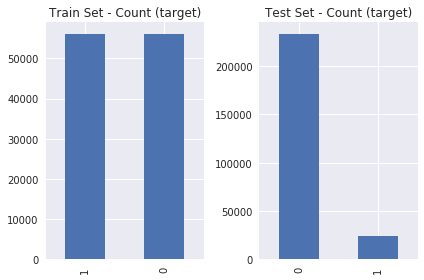

Training NB_grid_5cv_recall classifier
No params set, using Standard training
Generating test scores for NB_grid_5cv_recall classifier
Performing 5-fold CV on test set using recall metric
Training DT_grid_5cv_recall classifier
Optimising using GridSearchCV
Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   13.6s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:  5.1min finished


CLF: {'class_weight': None, 'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 15, 'min_samples_split': 1000, 'presort': False}
Generating test scores for DT_grid_5cv_recall classifier
Performing 5-fold CV on test set using recall metric
Training RF_grid_5cv_recall classifier
Optimising using GridSearchCV
Fitting 5 folds for each of 32 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/home/anaconda/envs/py373/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:  7.5min finished


CLF: {'class_weight': None, 'criterion': 'entropy', 'max_depth': 25, 'min_samples_leaf': 10, 'min_samples_split': 2, 'n_estimators': 100}
Generating test scores for RF_grid_5cv_recall classifier
Performing 5-fold CV on test set using recall metric
Training LR_grid_5cv_recall classifier
Optimising using GridSearchCV
Fitting 5 folds for each of 32 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.3min
/home/anaconda/envs/py373/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:  7.6min finished
/home/anaconda/envs/py373/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


CLF: {'C': 2, 'class_weight': None, 'max_iter': 200, 'solver': 'lbfgs'}
Generating test scores for LR_grid_5cv_recall classifier
Performing 5-fold CV on test set using recall metric
Training MLP_grid_5cv_recall classifier
Optimising using GridSearchCV
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.4min
/home/anaconda/envs/py373/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  2.0min finished


CLF: {'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': (100,)}
Generating test scores for MLP_grid_5cv_recall classifier
Performing 5-fold CV on test set using recall metric
Training XGB_grid_5cv_recall classifier
Optimising using GridSearchCV
Fitting 5 folds for each of 27 candidates, totalling 135 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.9min
/home/anaconda/envs/py373/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done 135 out of 135 | elapsed: 17.4min finished


CLF: {'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 300}
Generating test scores for XGB_grid_5cv_recall classifier
Performing 5-fold CV on test set using recall metric


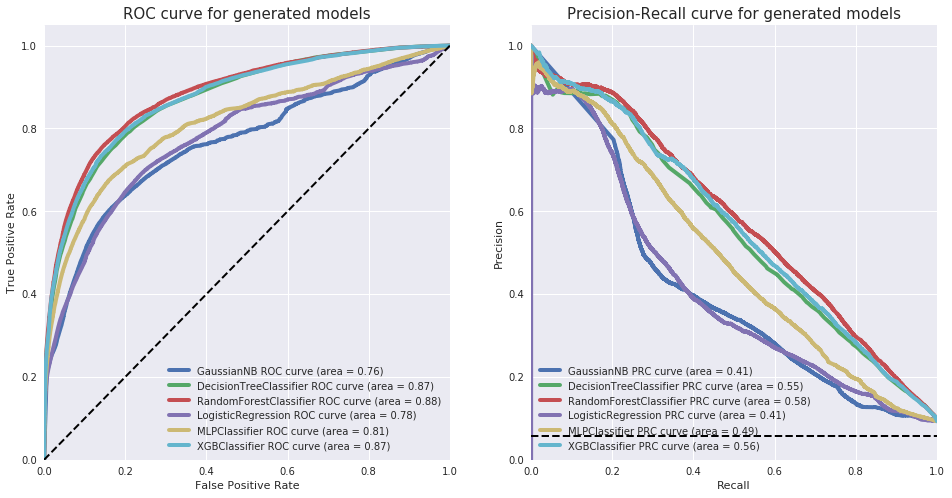

CPU times: user 5min 26s, sys: 26.1 s, total: 5min 52s
Wall time: 57min 50s


In [10]:
%%time
start = time.time()

sampler = ('RUS 1:1', RandomUnderSampler(random_state=RANDOM_STATE))

exp_metrics, model_results = perform_experiment(X_train, X_test, y_train, y_test, classifiers, sampler, 1, \
                                                cv_iter=CV_ITER, cat_col=cat_col)

all_metrics = all_metrics.append(exp_metrics)
all_results.append((sampler[0]+"_"+BASE_NAME, exp_metrics, model_results))

log("manual, grid_search, {0}, {1}".format(sampler[0], time.time()-start), 'Manual_GridSearch.log')

In [18]:
all_metrics[all_metrics.sampling_method=='None'][['classifier','train_time','cv_time', 'recall']]

,classifier,train_time,cv_time,recall
0,GaussianNB,3.71,2.65,0.57
0,DecisionTreeClassifier,9849.19,15.65,0.79
0,RandomForestClassifier,3808.09,36.38,0.75
0,LogisticRegression,2642.69,14.44,0.69
0,MLPClassifier,2848.76,253.56,0.29
0,XGBClassifier,4915.03,200.61,0.28


### Experiment 1.4 Baseline - Default Settings - Over sampling - 33% of majority size

In [ ]:
%%time
start = time.time()

sampler = ('ROS 3:1', RandomOverSampler(random_state=RANDOM_STATE, sampling_strategy = 1/3))

exp_metrics, model_results = perform_experiment(X_train, X_test, y_train, y_test, classifiers, sampler, 1, \
                                                cv_iter=CV_ITER, cat_col=cat_col)

all_metrics = all_metrics.append(exp_metrics)
all_results.append((sampler[0]+"_"+BASE_NAME, exp_metrics, model_results))

log("manual, grid_search, {0}, {1}".format(sampler[0], time.time()-start), 'Manual_GridSearch.log')

### Experiment 1.5 Baseline - Default Settings - Over sampling - 66% of majority size

In [ ]:
%%time
start = time.time()

sampler = ('ROS 3:2', RandomOverSampler(random_state=RANDOM_STATE, sampling_strategy = 2/3))

exp_metrics, model_results = perform_experiment(X_train, X_test, y_train, y_test, classifiers, sampler, 1, \
                                                cv_iter=CV_ITER, cat_col=cat_col)

all_metrics = all_metrics.append(exp_metrics)
all_results.append((sampler[0]+"_"+BASE_NAME, exp_metrics, model_results))

log("manual, grid_search, {0}, {1}".format(sampler[0], time.time()-start), 'Manual_GridSearch.log')

### Experiment 1.6 Baseline - Default Settings - Over sampling - 50% of majority size

In [ ]:
%%time
start = time.time()

sampler = ('ROS 2:1', RandomOverSampler(random_state=RANDOM_STATE, sampling_strategy = 1/2))

exp_metrics, model_results = perform_experiment(X_train, X_test, y_train, y_test, classifiers, sampler, 1, \
                                                cv_iter=CV_ITER, cat_col=cat_col)

all_metrics = all_metrics.append(exp_metrics)
all_results.append((sampler[0]+"_"+BASE_NAME, exp_metrics, model_results))

log("manual, grid_search, {0}, {1}".format(sampler[0], time.time()-start), 'Manual_GridSearch.log')

### Experiment 1.7 Baseline Default Settings SMOTE-NC

In [ ]:
%%time
start = time.time()

sampler = ('SMOTE_NC', SMOTENC(random_state=RANDOM_STATE, categorical_features=[0,1,2,3,4,5,6,7,8,13,14], n_jobs=8))

## Keep the following, essentially dropping the dt columns
cols = ['is_churn', 'city', 'gender', 'age_cat', 'registered_via', 'total_order',
       'payment_method_id_mode', 'payment_method_id_count',
       'payment_plan_days_mode', 'payment_plan_days_mean',
       'plan_list_price_mean', 'plan_lifetime_value', 'actual_amount_mean',
       'total_actual_amount', 'is_auto_renew_mode', 'cancel_times','transaction_date_delta']

exp_metrics, model_results = perform_experiment(X_train, X_test, y_train, y_test, classifiers, sampler, 1, \
                                                cv_iter=CV_ITER, cat_col=cat_col)

all_metrics = all_metrics.append(exp_metrics)
all_results.append((sampler[0]+"_"+BASE_NAME, exp_metrics, model_results))

log("manual, grid_search, {0}, {1}".format(sampler[0], time.time()-start), 'Manual_GridSearch.log')

In [ ]:
all_metrics.sort_values('recall', ascending=False)

### Persist results to disk

In [19]:
# Write (overwrite) the file to store the experiment results
with open('Manual_GridSearch_2019-08-05.pickle', 'wb') as f:
    # Pickle the 'data' dictionary using the highest protocol available.
    print("Writing results to", f.name)
    pickle.dump(all_results, f, pickle.HIGHEST_PROTOCOL)

Writing results to Manual_GridSearch_2019-08-05.pickle


### Sort the results and get the best sampling config per classifier 

In [ ]:
top_results = all_metrics.sort_values(['balanced_accuracy'], ascending=[False]).groupby('classifier').head(1)
top_results

### Graph the results base on the list of best classifiers above

In [ ]:
temp = filter_top_model_results(top_results, all_results)
plot_roc_prc(temp)

In [ ]:
## Just try an SVM 
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier

In [ ]:
%%time
model_train_results = train_model(base_dataset, sampling_method = 'under', classifiers = [('SGDClassifier', SGDClassifier(loss='log'))])

In [ ]:
## Print the feature importance 

feature_index = np.flip(np.argsort(model.feature_importances_), axis=0)
ordered_features = []
column_names = X_test.columns

for i in feature_index[0:10]:
    print(np.round(model.feature_importances_[i], 3), ' --> ', column_names[i])
    ordered_features.append(column_names[i])

In [ ]:
## Print the permutation importance 

import eli5
from eli5.sklearn import PermutationImportance

_, X_test, _, y_test = prepare_train_test_split(model_dataset, 0)

perm = PermutationImportance(model, random_state=1).fit(X_test, y_test)

eli5.show_weights(perm, feature_names = X_test.columns.tolist())

In [ ]:
#model_name, model = model_train_results[1][2]

for model_name, model in model_train_results[1]:
    probs = model.predict_proba(X_test)[:, 1]
    pr_data = plot_precision_recall(
        y_test, probs, title='PR Curve for {0}'.format(model_name))

In [ ]:
probs = model.predict_proba(X_test)[:, 1]
pr_data = plot_precision_recall(
    y_test, probs, title='PR Curve for {0}'.format(model_name))

In [ ]:
pr_data = plot_roc(
    y_test, probs, title='ROC Curve for {0}'.format(model_name))

In [ ]:
print(plt.style.available)

In [ ]:
model_dataset.head()

In [ ]:
print("Original Data distribution")
print(model_dataset['is_churn'].value_counts())

In [ ]:
# Display new class counts
print('Sci-Kit Learn : resample : Down Sampled data set')
train_downsample = undersampled_dataset(model_dataset, 'is_churn')

print(train_downsample['is_churn'].value_counts())
print("Num records = ", train_downsample.shape[0])
train_downsample.is_churn.value_counts().plot(kind='bar', title='Count (target)')

In [ ]:
# Display new class counts
print('Sci-Kit Learn : resample : Up Sampled data set')
train_upsample = oversampled_dataset(model_dataset, 'is_churn')

print(train_upsample['is_churn'].value_counts())
print("Num records = ", train_upsample.shape[0])
train_upsample.is_churn.value_counts().plot(kind='bar', title='Count (target)')

In [ ]:
probs = model.predict_proba(X_test)[:, 1]
pr_data = plot_precision_recall(
    y_test, probs, title='Precision-Recall Curve for Random Forest')

In [ ]:
precision_above = pr_data.loc[pr_data['precision'] >= 0.25].copy()
precision_above.sort_values('recall', ascending=False, inplace=True)
precision_above.head()

In [ ]:
threshold_required = 0.5
# Make predictions where probability is above threshold
preds = np.zeros(len(y_test))
preds[probs >= threshold_required] = 1

# Make and plot confusion matrix
cm = confusion_matrix(y_test, preds)
plot_confusion_matrix(cm, classes=['No Churn', 'Churn'],
                      title='Churn Confusion Matrix')

In [ ]:
model_dataset.head()

In [ ]:
fi = pd.DataFrame({'importance': model.feature_importances_}, index=model_dataset.iloc[:, 1:].columns).\
    sort_values('importance', ascending=False)
fi.head(10)